In [5]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.style.use('seaborn-white')
import dateutil
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats
from schemdraw import flow, Drawing

In [6]:
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
obs['week'] = obs['weeks old note'].str.split(' ').str[0].astype('float').astype('Int64')
obs_used = obs[obs['animal'].isin(animals_used)]
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int64')
ap = animal_phenotypes

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
df = pd.read_csv(r'..\data\processed\combined_metab_lipid_table.csv', index_col=0)
data_cols = df.filter(regex='FBG|RBG').columns
pval_cols = df.filter(regex='pval').columns

## Figure 1B: Blood glucose values RBG and FBG, averaged by tolerance 

In [7]:
# Random 
nbg = obs.loc[(obs['animal'].isin(normal)) & (obs['BG type'] == 'RBG') & (obs['BG'].notna())]
normal_rbgs = nbg.groupby(by='week').mean()['BG']
ibg = obs.loc[(obs['animal'].isin(impaired)) & (obs['BG type'] == 'RBG') & (obs['BG'].notna())]
impaired_rbgs = ibg.groupby(by='week').mean()['BG']
dbg = obs.loc[(obs['animal'].isin(diabetic)) & (obs['BG type'] == 'RBG') & (obs['BG'].notna())]
diabetic_rbgs = dbg.groupby(by='week').mean()['BG']
# Fasted
nbg = obs.loc[(obs['animal'].isin(normal)) & (obs['BG type'] == 'FBG') & (obs['BG'].notna())]
normal_fbgs = nbg.groupby(by='week').mean()['BG']
ibg = obs.loc[(obs['animal'].isin(impaired)) & (obs['BG type'] == 'FBG') & (obs['BG'].notna())]
impaired_fbgs = ibg.groupby(by='week').mean()['BG']
dbg = obs.loc[(obs['animal'].isin(diabetic)) & (obs['BG type'] == 'FBG') & (obs['BG'].notna())]
diabetic_fbgs = dbg.groupby(by='week').mean()['BG']

Text(0.5, 1.0, 'Blood glucose measurements\nMean of diabetic status')

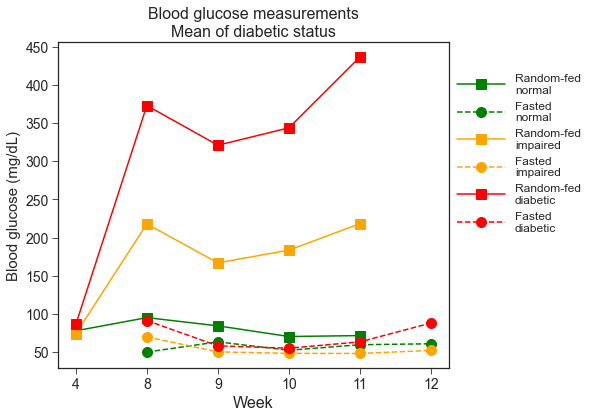

In [8]:
plt.style.use('seaborn-ticks')

rbg_weeks = ['4','8','9','10','11']
fbg_weeks = ['8','9','10','11','12']
plt.plot(rbg_weeks, normal_rbgs  ,   's-',  label='Random-fed\nnormal',   ms=10, c='green',  )
plt.plot(fbg_weeks, normal_fbgs  ,   'o--', label='Fasted\nnormal',       ms=10, c='green',  )
plt.plot(rbg_weeks, impaired_rbgs, 's-',  label='Random-fed\nimpaired', ms=10, c='orange', )
plt.plot(fbg_weeks, impaired_fbgs, 'o--', label='Fasted\nimpaired',     ms=10, c='orange', )
plt.plot(rbg_weeks, diabetic_rbgs, 's-',  label='Random-fed\ndiabetic', ms=10, c='red',    )
plt.plot(fbg_weeks, diabetic_fbgs, 'o--', label='Fasted\ndiabetic',     ms=10, c='red',    )

plt.legend(loc=(1.01, 0.4), handlelength=4, fontsize=12)
plt.gcf().set_size_inches((7, 6))
plt.xticks(ticks=[0,1,2,3,4,5], fontsize=14)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Blood glucose (mg/dL)', fontsize=15)
plt.yticks(fontsize=14)
plt.title('Blood glucose measurements\nMean of diabetic status', fontsize=16)



# Figure 1C: Body weight averaged by glucose tolerance category
## Use non-fasted weights
### 3 total lines

In [11]:
nweight = obs.loc[(obs['weight type'] == 'Weight') & \
                  (obs['BG type'] == 'RBG') & \
                  (obs['animal'].isin(normal))].groupby('week').mean()
nweight

,animal,BG,weight,weight change %
week,,,,
4,1092.0,78.00,41.20,NaN
8,1092.0,95.25,78.50,90.535103
9,1092.0,84.50,83.00,5.732484
10,1092.0,70.50,87.25,5.120562
11,1092.0,71.75,90.40,3.610940


In [12]:
weight = obs.loc[(obs['weight type'] == 'Weight') & \
                  ((obs['BG type'] == 'RBG') | (obs['BG type'] == 'Post-OGTT BG'))] 
nweight = weight.loc[weight['animal'].isin(normal)].groupby('week').mean()['weight']
iweight = weight.loc[weight['animal'].isin(impaired)].groupby('week').mean()['weight']
dweight = weight.loc[weight['animal'].isin(diabetic)].groupby('week').mean()['weight']
nweight

week
4     41.20
8     78.50
9     83.00
10    87.25
11    90.40
12    90.95
Name: weight, dtype: float64

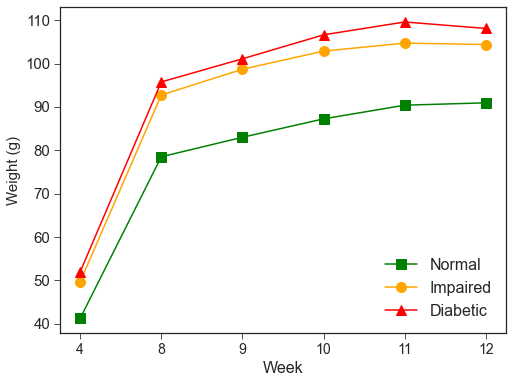

In [13]:
weight_weeks = ['4','8','9','10','11','12']
plt.plot(weight_weeks, nweight, 's-',  label='Normal',   ms=10, c='green')
plt.plot(weight_weeks, iweight, 'o-',  label='Impaired', ms=10, c='orange')
plt.plot(weight_weeks, dweight, '^-',  label='Diabetic', ms=10, c='red')

plt.legend(fontsize=16)
plt.gcf().set_size_inches((8, 6))
plt.xticks(ticks=[0,1,2,3,4,5,], fontsize=14)
plt.xlabel('Week', fontsize=16)
plt.yticks(fontsize=15)
plt.ylabel('Weight (g)', fontsize=15)

ax2 = plt.gca()
# plt.plot(rbg_weeks, normal_rbgs  ,   's-',  label='Random-fed\nnormal',   ms=10, c='green',  )
# plt.plot(fbg_weeks, normal_fbgs  ,   'o--', label='Fasted\nnormal',       ms=10, c='green',  )
# plt.plot(rbg_weeks, impaired_rbgs, 's-',  label='Random-fed\nimpaired', ms=10, c='orange', )
# print('')

## Combine Fig 1B and 1C into one 

In [14]:
# with Drawing() as d:
#     d += flow.Box().label('START')
#     d += flow.Arrow().down(d.unit/3)
#     h = flow.Decision(w=5.5, h=4, S='YES').label('Hey, wait,\nthis flowchart\nis a trap!')
#     d += h
#     d += flow.Line().down(d.unit/4)
#     d += flow.Wire('c', k=3.5, arrow='->').to(h.E)

In [15]:
fig = mpl.figure.Figure
ax = [mpl.axes.Axes, mpl.axes.Axes]

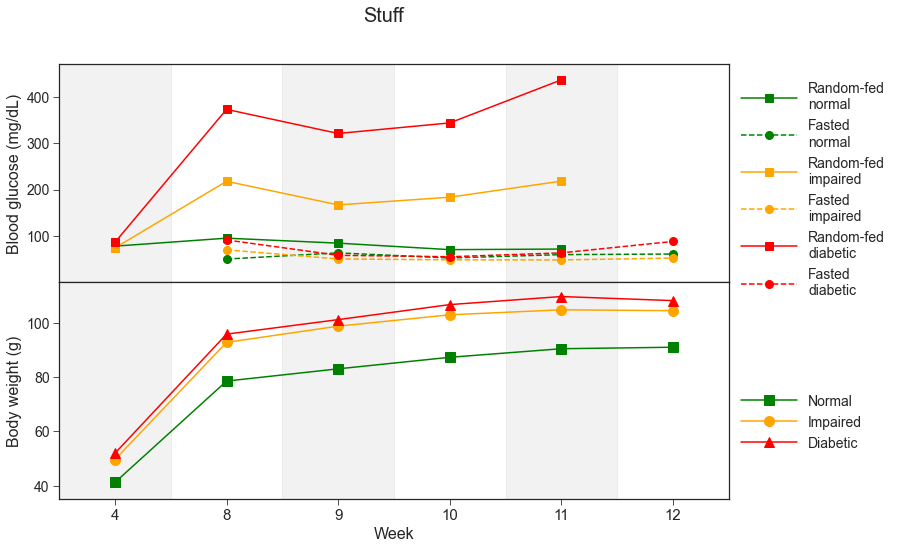

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.subplots_adjust(hspace=0.00)
# fig.xlim((0,10))
fig.set_size_inches((12, 8))
fig.suptitle('Stuff', fontsize=20)
# fig.supylabel('')
# plt.yticks(fontsize=15)

ax[0].plot(rbg_weeks, normal_rbgs  ,   's-',  label='Random-fed\nnormal',   ms=8, c='green',  )
ax[0].plot(fbg_weeks, normal_fbgs  ,   'o--', label='Fasted\nnormal',       ms=8, c='green',  )
ax[0].plot(rbg_weeks, impaired_rbgs,   's-',  label='Random-fed\nimpaired', ms=8, c='orange', )
ax[0].plot(fbg_weeks, impaired_fbgs,   'o--', label='Fasted\nimpaired',     ms=8, c='orange', )
ax[0].plot(rbg_weeks, diabetic_rbgs,   's-',  label='Random-fed\ndiabetic', ms=8, c='red',    )
ax[0].plot(fbg_weeks, diabetic_fbgs,   'o--', label='Fasted\ndiabetic',     ms=8, c='red',    )
ax[0].legend(loc=(1.01, -0.1), fontsize=14, handlelength=4)
ax[0].tick_params(axis='y', labelsize=14)
ax[0].set_ylabel('Blood glucose (mg/dL)', fontsize=16)
ax[0].set_ylim(1, 470)

# ax[0].set_xticks(ticks=[0,1,2,3,4,5])
# ax[0].set_xticklabels(labels=['4','8','9','10','11','12'])

ax[1].plot(weight_weeks, nweight, 's-',  label='Normal',   ms=10, c='green')
ax[1].plot(weight_weeks, iweight, 'o-',  label='Impaired', ms=10, c='orange')
ax[1].plot(weight_weeks, dweight, '^-',  label='Diabetic', ms=10, c='red')
ax[1].set_ylabel('Body weight (g)', fontsize=16)
ax[1].legend(loc=(1.01, 0.2), fontsize=14, handlelength=4)
ax[1].tick_params(axis='y', labelsize=14)
ax[1].set_ylim(35, 115)

# Make nice gray backgrounds:
for a in ax:
    for i1, i2 in zip(np.arange(-0.5, 4.5, 2), np.arange(0.5, 5.5, 2)):
        a.axvspan(i1, i2, color='gray', alpha=0.1)

plt.xticks(fontsize=15)
plt.xlabel('Week', fontsize=16)
plt.xlim(-0.5, 5.5)

plt.savefig(r'..\reports\figures\0-1-1\combined_metadata.svg')

# Figure 1D
## Area under Curve of OGTT 

In [20]:
for i, row in nogtt.iterrows():
    print(row)
    break

NameError: name 'nogtt' is not defined

In [21]:
t = ogtt.iloc[0]
t

NameError: name 'ogtt' is not defined

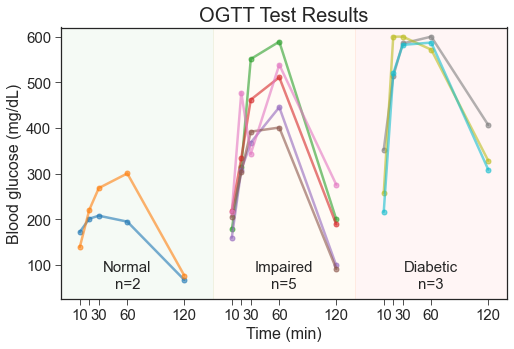

In [24]:
ogtt = ap.loc[ap['animal'].isin(animals_used)].filter(regex='OGTT|animal').set_index('animal').iloc[:, :-1]
# ogtt = ap.filter(regex='OGTT|animal').set_index('animal').iloc[:, :-1]
nogtt = ogtt.loc[ogtt.index.isin(normal)]
iogtt = ogtt.loc[ogtt.index.isin(impaired)]
dogtt = ogtt.loc[ogtt.index.isin(diabetic)]

plt.style.use('seaborn-ticks')
plt.gcf().set_size_inches((8, 5))

xnorm = [10, 20, 30, 60, 120]
xlabels = ['10', '', '30', '60', '120']
ximp = [x + 160 for x in xnorm]
xdia = [x + 320 for x in xnorm]
for df, tol in zip([nogtt, iogtt, dogtt], ['n', 'i', 'd']):
    for i, row in df.iterrows():
        if tol == 'n':
            x = xnorm
        elif tol == 'i':
            x = ximp
        else:
            x = xdia
        plt.plot(x, row, '.-', alpha=0.6, lw=2.5, ms=10)
        # make an array of points in a line that connect start point to end point
#         plt.fill_between(x, y1=row, y2=0, alpha=0.1)

plt.ylabel('Blood glucose (mg/dL)', fontsize=16)
plt.yticks(fontsize=15)
plt.ylim(25, 620)
plt.xticks(ticks=(xnorm+ximp+xdia), labels=xlabels*3, fontsize=15);
plt.xlabel('Time (min)', fontsize=16)
plt.xlim(-10, 460)
ax = plt.gca()
ax.axvspan(-10, 150, color='green', alpha=0.04, label='Normal')
ax.axvspan(150, 300, color='orange', alpha=0.04, label='Impaired')
ax.axvspan(300, 460, color='red', alpha=0.04, label='Diabetic')

# handles, labels = ax.get_legend_handles_labels()
# handles = [handle.set_fill('black') for handle in handles]
# ax.legend(loc=(1.01, 0.5), fontsize=15)
plt.annotate('Normal\nn=2',   (60,  50), fontsize=15, ha='center')
plt.annotate('Impaired\nn=5', (225, 50), fontsize=15, ha='center')
plt.annotate('Diabetic\nn=3', (380, 50), fontsize=15, ha='center')
plt.title('OGTT Test Results', fontsize=20)

plt.savefig(r'..\reports\figures\0-1-1\OGTT_AUCs.svg')

### The normal/impaired/diabetic classification came from the oral glucose test (OGTT) 

The OGTT area under curve (AUC) gives the integration of the OGTT blood glucose test based on the time points between 0 and 120 minutes 

### Use a K-means clustering method to derive cut-off values for k groups of glucose tolerance 

Because K-means uses a distance metric, it is suggested to use Standardized data. However, based on the shape of the graphs below elbow plots below, it doesn't make a difference as to the number of clusters. 

[[1761.75]
 [1674.8 ]
 [1648.75]
 [1350.25]
 [3365.  ]
 [2321.25]
 [2354.75]
 [2224.75]
 [ 846.75]
 [1377.95]
 [ 993.  ]
 [ 842.75]
 [1401.25]
 [2015.75]
 [1738.25]]


Text(0.5, 1.0, 'Elbow plot of K-means clusters')

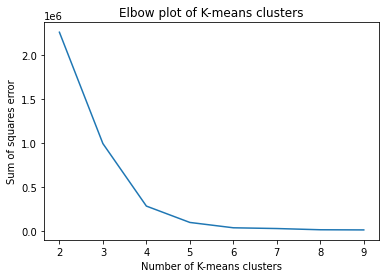

In [129]:
ogtt_auc = np.array(animal_phenotypes.loc[animal_phenotypes['OGTT (AUC)'].notna(), 'OGTT (AUC)']).reshape(-1, 1)
print(ogtt_auc)
ss_errors = []
ss_errors_scaled = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, init='random', random_state=1000)
    kmeans.fit(ogtt_auc)
    ss_errors.append(kmeans.inertia_)
    
    kmeans_scaled = KMeans(n_clusters=k, init='random', random_state=1000)
    kmeans_scaled.fit(StandardScaler().fit_transform(ogtt_auc))
    ss_errors_scaled.append(kmeans_scaled.inertia_)

plt.plot(range(2, 10), ss_errors)
plt.ylabel('Sum of squares error')
plt.xlabel('Number of K-means clusters')
plt.title('Elbow plot of K-means clusters')

# plt.figure()
# plt.plot(range(2, 10), ss_errors_scaled)

In [46]:
ogtt_auc.reshape(-1)

array([1761.75, 1674.8 , 1648.75, 1350.25, 3365.  , 2321.25, 2354.75,
       2224.75,  846.75, 1377.95,  993.  ,  842.75, 1401.25, 2015.75,
       1738.25])

In [86]:
ogtt_auc_animals_used = animal_phenotypes.loc[animal_phenotypes['animal'].isin(animals_used), 'OGTT (AUC)']
ogtt_auc_animals_used

0     1761.75
2     1648.75
4     1350.25
6     2321.25
9     2224.75
10     846.75
11    1377.95
12     993.00
17    2015.75
18    1738.25
Name: OGTT (AUC), dtype: float64

In [95]:
ogtt_auc_animals_not_used = animal_phenotypes.loc[~animal_phenotypes['animal'].isin(animals_used), 'OGTT (AUC)'].dropna()
ogtt_auc_animals_not_used

1     1674.80
5     3365.00
8     2354.75
13     842.75
15    1401.25
Name: OGTT (AUC), dtype: float64

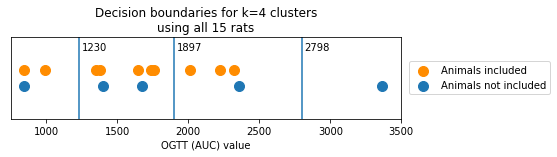

In [128]:
# Plot OGTT AUC data on 1-D plot, with decision boundaries

test_data = np.arange(3500).reshape(-1, 1)

# kmeans_2 = KMeans(n_clusters=2, init='random', random_state=1000)
# kmeans_2.fit(ogtt_auc)

# plt.gcf().set_size_inches((7, 2))
# plt.scatter(ogtt_auc.reshape(-1), [0]*15)
# plt.xlim((750, 3500))
# plt.ylim((-0.01, 0.01))
# k2_pred = list(kmeans_2.predict(test_data))
# # From the test data, get the .index of the first instance of each cluster, giving the boundary line
# for index in range(0, 2):
#     plt.vlines(k2_pred.index(index), ymin=-1, ymax=1)
# plt.yticks([])
# plt.xlabel('OGTT (AUC) value')
# plt.title('Decision boundaries for k=2 clusters\nusing all 15 rats')


# kmeans_3 = KMeans(n_clusters=3, init='random', random_state=1000)
# kmeans_3.fit(ogtt_auc)
# plt.figure()
# plt.gcf().set_size_inches((7, 2))
# plt.scatter(ogtt_auc.reshape(-1), [0]*15)
# plt.xlim((700, 3500))
# plt.ylim((-0.01, 0.01))
# k3_pred = list(kmeans_3.predict(test_data))
# # From the test data, get the .index of the first instance of each cluster, giving the boundary line
# for index in range(0, 3):
#     plt.vlines(k3_pred.index(index), ymin=-1, ymax=1)
# plt.yticks([])
# plt.xlabel('OGTT (AUC) value')
# plt.title('Decision boundaries for k=3 clusters\nusing all 15 rats')


kmeans_4 = KMeans(n_clusters=4, init='random', random_state=1000)
kmeans_4.fit(ogtt_auc)
plt.figure()
plt.gcf().set_size_inches((7, 1.5))
plt.scatter(ogtt_auc_animals_used, [0.2]*10, s=100, c='darkorange', label='Animals included')
plt.scatter(ogtt_auc_animals_not_used, [-0.2]*5, s=100, label='Animals not included')
plt.xlim((750, 3500))
plt.ylim((-1, 1))
k4_pred = list(kmeans_4.predict(test_data))
# From the test data, get the .index of the first instance of each cluster, giving the boundary line
for index in range(1, 4):
    plt.vlines(k4_pred.index(index), ymin=-1, ymax=1)
    plt.annotate(str(k4_pred.index(index)), xy=(k4_pred.index(index)+20, 0.69))
plt.yticks([])
plt.xlabel('OGTT (AUC) value')
plt.title('Decision boundaries for k=4 clusters\nusing all 15 rats')
plt.legend(loc=(1.02, 0.3))

Text(0.5, 1.0, 'Decision boundaries for k=4 clusters\nusing all 15 rats')

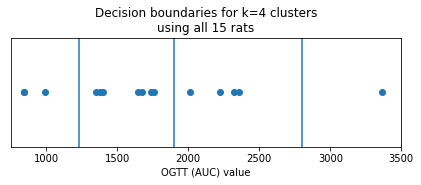

In [74]:
kmeans_4 = KMeans(n_clusters=4, init='random', random_state=1000)
kmeans_4.fit(ogtt_auc)

plt.gcf().set_size_inches((7, 2))
plt.scatter(ogtt_auc.reshape(-1), [0]*15)
plt.xlim((750, 3500))
plt.ylim((-0.01, 0.01))
k4_pred = list(kmeans_4.predict(test_data))
# From the test data, get the .index of the first instance of each cluster, giving the boundary line
for index in range(1, 4):
    plt.vlines(k4_pred.index(index), ymin=-1, ymax=1)
plt.yticks([])
plt.xlabel('OGTT (AUC) value')
plt.title('Decision boundaries for k=4 clusters\nusing all 15 rats')

In [144]:
# pt = phenotypes of animals sampled for LCMS
pt = animal_phenotypes[animal_phenotypes['animal'].isin(animals_used)].sort_values('glucose_tolerance')
pt

,animal,Date of birth,lcms_sampled,glucose_tolerance,10.6g dextrose in 6mL distilled water; total 12.5mL solution,OGTT(10min),OGTT(20min),OGTT(30min),OGTT(60min),OGTT(120min),OGTT (AUC),HbA1c,Interscapular brown fat (g),BF (%BW),Inguinal white fat one side (g),WF (%BW),BF/WF,Plasma,Fatty liver,Notes
6,1076,2021-01-23,True,diabetic,138.0,352.5,513.5,585.0,600.0,406.5,2321.25,NaN,1.4332,1.278501,0.6960,0.620874,2.059195,White,Slight,NaN
9,1082,2021-01-24,True,diabetic,62.0,258.0,600.0,600.0,571.5,328.5,2224.75,NaN,0.8904,0.818382,0.6515,0.598805,1.366692,White,Yes,NaN
17,1101,2021-02-01,True,diabetic,64.5,216.5,519.5,582.0,587.0,309.0,2015.75,NaN,0.9262,0.838190,0.6216,0.562534,1.490026,murky,Yes definitely,NaN
0,1060,2021-01-23,True,impaired,58.5,178.0,314.5,551.0,589.0,200.0,1761.75,NaN,2.0448,1.945576,0.7185,0.683635,2.845929,murky,No,NaN
2,1062,2021-01-23,True,impaired,56.5,219.0,334.0,462.0,511.0,189.0,1648.75,NaN,2.5185,2.308433,0.7439,0.681852,3.385536,murky,No,NaN
4,1074,2021-01-23,True,impaired,38.5,160.0,308.0,368.0,445.5,99.0,1350.25,NaN,2.5060,2.269928,0.7164,0.648913,3.498046,murky,Slight,NaN
11,1092,2021-01-31,True,impaired,59.5,206.0,303.5,392.0,401.0,91.5,1377.95,NaN,1.2902,1.312513,0.6312,0.642116,2.044043,clear,Slight,NaN
18,1102,2021-02-01,True,impaired,48.5,216.5,477.5,343.5,538.5,276.0,1738.25,NaN,1.7053,1.405853,0.8780,0.723825,1.942255,murky,Very slight,NaN
10,1091,2021-01-31,True,normal,72.0,172.5,201.5,208.0,195.0,67.5,846.75,NaN,1.4930,1.615801,0.5354,0.579437,2.788569,clear,Slight,NaN
12,1093,2021-01-31,True,normal,50.0,139.5,221.0,268.5,300.5,77.0,993.00,NaN,1.1374,1.203598,0.5462,0.577989,2.082387,clear,Yes,NaN


Text(0, 0.5, 'AUC')

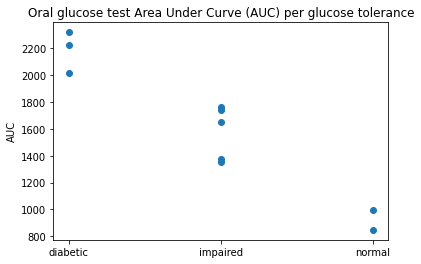

In [145]:
plt.scatter(pt['glucose_tolerance'], pt['OGTT (AUC)'])
plt.title('Oral glucose test Area Under Curve (AUC) per glucose tolerance')
plt.ylabel('AUC')

Text(0.5, 1.0, 'OGTT result by rat date of birth')

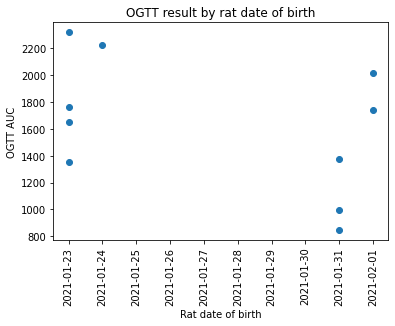

In [146]:
plt.scatter(pt['Date of birth'], pt['OGTT (AUC)'])
plt.xticks(rotation=90)
plt.xlabel('Rat date of birth')
plt.ylabel('OGTT AUC')
plt.title('OGTT result by rat date of birth')# \n(Includes rats not sampled for LC-MS)')

<AxesSubplot:xlabel='datetime'>

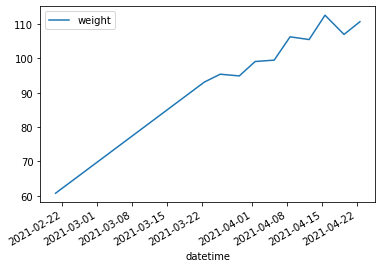

In [147]:
obs_used[(obs_used['weight type'] == 'Weight') & (obs_used['animal'] == 1076)][['datetime', 'weight']].plot('datetime', 'weight')

<AxesSubplot:xlabel='datetime'>

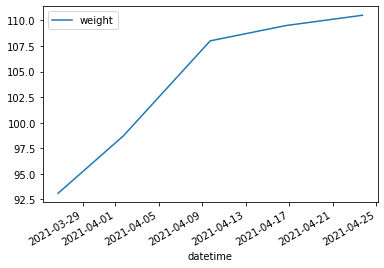

In [148]:
obs_used[(obs_used['weight type'] == 'Weight (pre-fasting)') & (obs_used['animal'] == 1101)][['datetime', 'weight']].plot('datetime', 'weight')

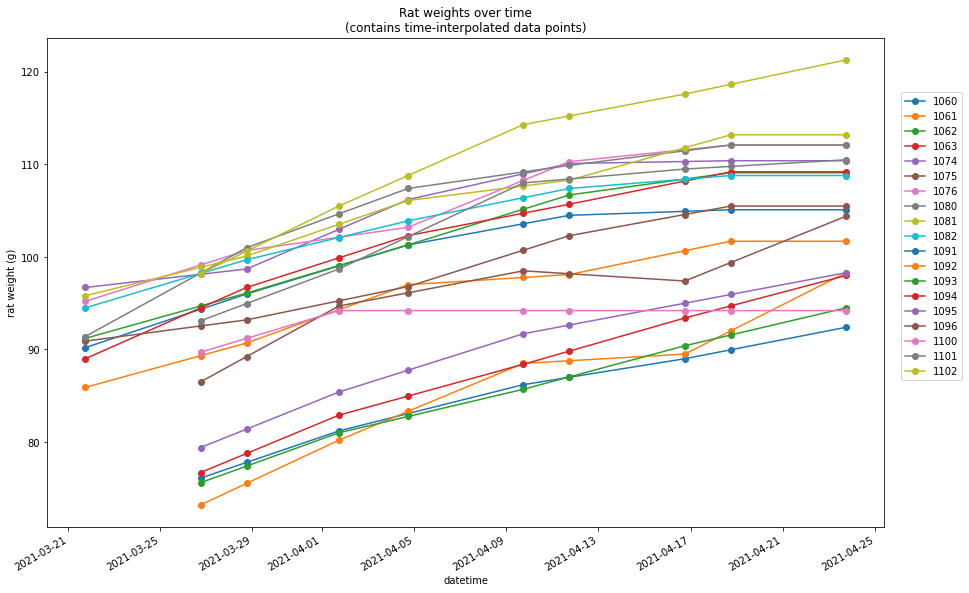

In [151]:
obs_used[(obs_used['weight type'] == 'Weight (pre-fasting)') & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'weight', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='weight')\
    .interpolate(method='time')\
    .plot(marker='o')

plt.gcf().set_size_inches(15, 10)
plt.ylabel('rat weight (g)')
plt.title('Rat weights over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.02, 0.3))

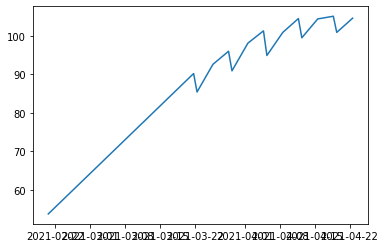

In [58]:
obs_used[obs_used['animal'] == 1060][['datetime', 'weight']]

plt.plot(obs_used[obs_used['animal'] == 1060][['datetime',]], obs_used[obs_used['animal'] == 1060][['weight']])

In [28]:
obs_used['BG type'].unique()

array(['RBG', 'RBG (pre-fasting)', 'FBG', 'Post-OGTT BG'], dtype=object)

In [29]:
obs_used['weight type'].unique()

array(['Weight', 'Weight (pre-fasting)'], dtype=object)

In [122]:
obs_used

,animal,when,BG,weight,weight change %,BG type,weight type,weight change type,weeks old note,note,datetime
0,1060,2/20 3pm,71.0,53.7,NaN,RBG,Weight,change,4 weeks old,NaN,2021-02-20 15:00:00
2,1062,2/20 3pm,78.0,51.3,NaN,RBG,Weight,change,4 weeks old,NaN,2021-02-20 15:00:00
4,1074,2/20 3pm,70.0,55.8,NaN,RBG,Weight,change,4 weeks old,NaN,2021-02-20 15:00:00
6,1076,2/20 3pm,96.0,60.7,NaN,RBG,Weight,change,4 weeks old,NaN,2021-02-20 15:00:00
9,1082,2/20 3pm,90.0,54.1,NaN,RBG,Weight,change,4 weeks old,NaN,2021-02-20 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...
295,1091,4/27 3pm,68.0,89.6,NaN,Post-OGTT BG,Weight,gain,12 weeks old,NaN,2021-04-27 15:00:00
296,1092,4/27 3pm,44.0,97.5,NaN,Post-OGTT BG,Weight,gain,12 weeks old,NaN,2021-04-27 15:00:00
297,1093,4/27 3pm,65.0,92.3,NaN,Post-OGTT BG,Weight,gain,12 weeks old,NaN,2021-04-27 15:00:00
302,1101,4/27 3pm,NaN,NaN,NaN,Post-OGTT BG,Weight,gain,12 weeks old,Missing data,2021-04-27 15:00:00


In [136]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .dropna(axis=0, how='all')

animal,1060,1062,1074,1076,1082,1091,1092,1093,1101,1102
datetime,,,,,,,,,,
2021-03-25 15:00:00,225.0,256.5,232.5,387.666667,272.0,NaN,NaN,NaN,NaN,NaN
2021-03-30 15:00:00,NaN,NaN,NaN,NaN,NaN,108.5,76.0,82.0,459.500000,299.5
2021-04-01 15:00:00,83.0,250.5,203.5,281.000000,339.5,NaN,NaN,NaN,NaN,NaN
2021-04-06 15:00:00,NaN,NaN,NaN,NaN,NaN,86.0,70.5,83.0,342.666667,227.5
2021-04-08 15:00:00,206.0,139.5,205.5,349.000000,330.5,NaN,NaN,NaN,NaN,NaN
2021-04-13 15:00:00,NaN,NaN,NaN,NaN,NaN,71.5,59.0,69.5,352.000000,308.0
2021-04-15 15:00:00,221.0,248.5,225.5,391.500000,413.0,NaN,NaN,NaN,NaN,NaN
2021-04-20 15:00:00,NaN,NaN,NaN,NaN,NaN,78.0,58.0,65.5,505.500000,338.5


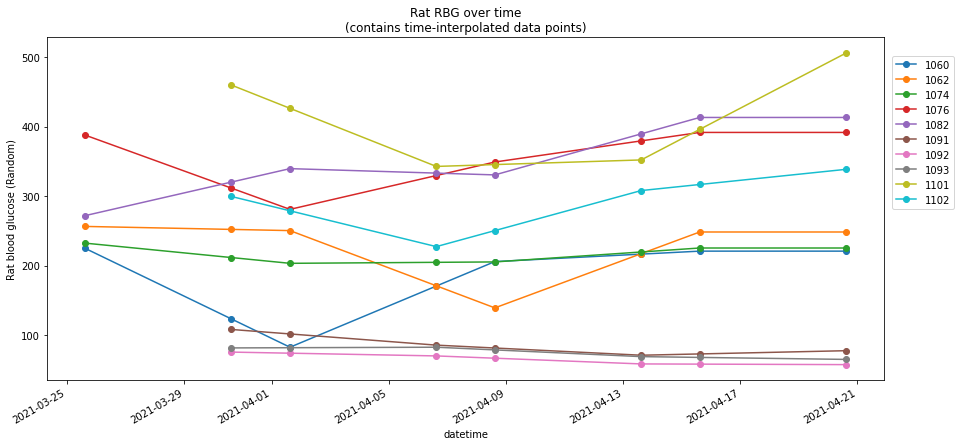

In [140]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .dropna(axis=0, how='all')\
    .interpolate(method='time')\
    .plot(marker='o')

plt.gcf().set_size_inches(15, 7)
plt.ylabel('Rat blood glucose (Random)')
plt.title('Rat RBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

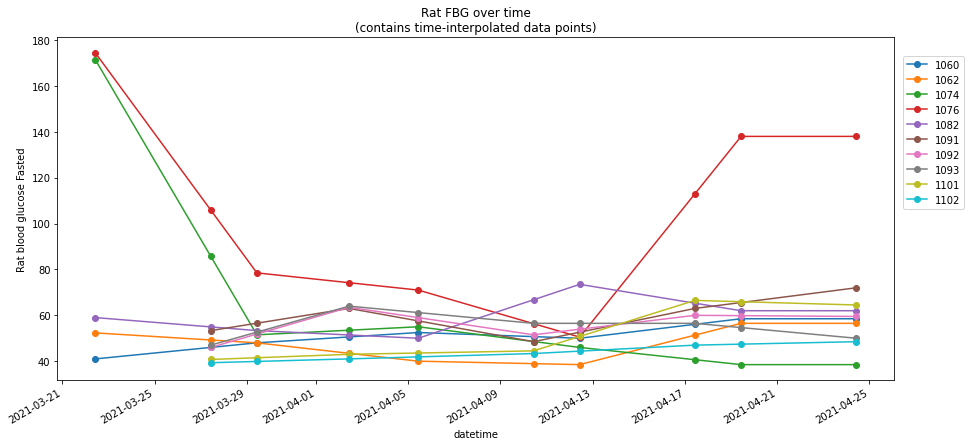

In [160]:
obs_used[(obs_used['BG type'] == 'FBG') & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot(marker='o')

plt.gcf().set_size_inches(15, 7)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Rat FBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

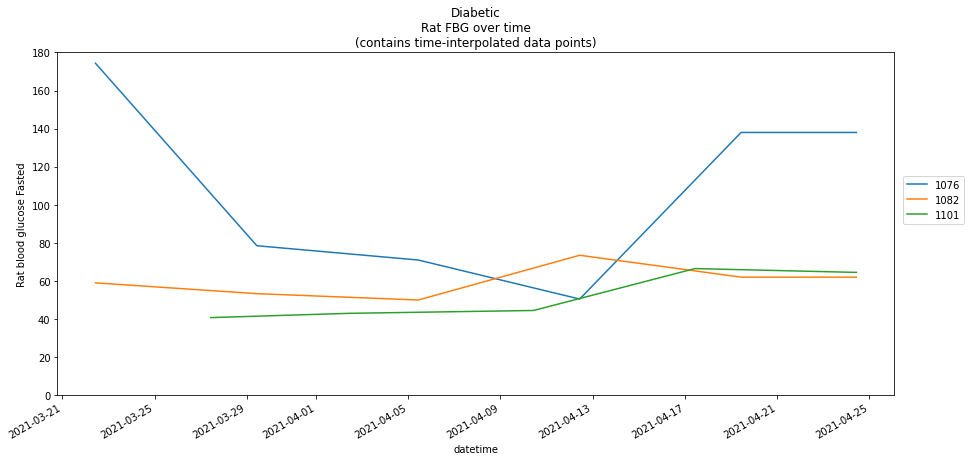

In [167]:
obs_used[(obs_used['BG type'] == 'FBG') & (obs_used['animal'].isin(diabetic)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 180)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Diabetic\nRat FBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

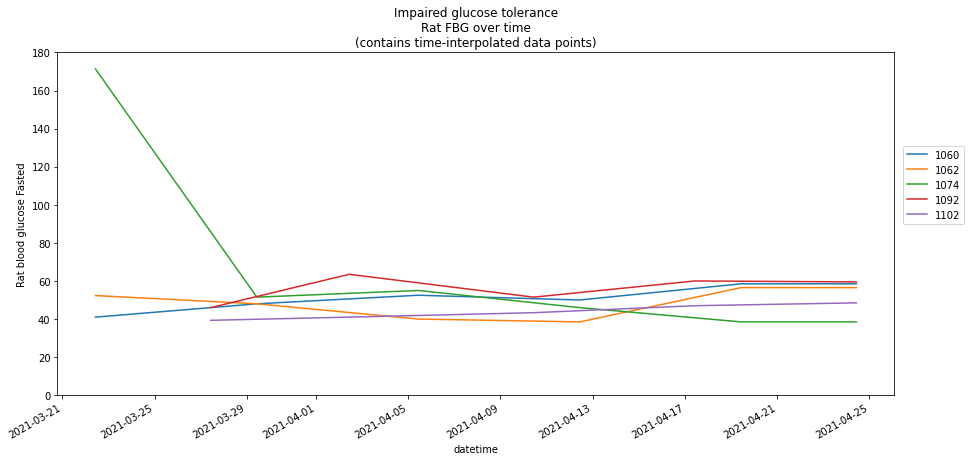

In [168]:
obs_used[(obs_used['BG type'] == 'FBG') & (obs_used['animal'].isin(impaired)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 180)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Impaired glucose tolerance\nRat FBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

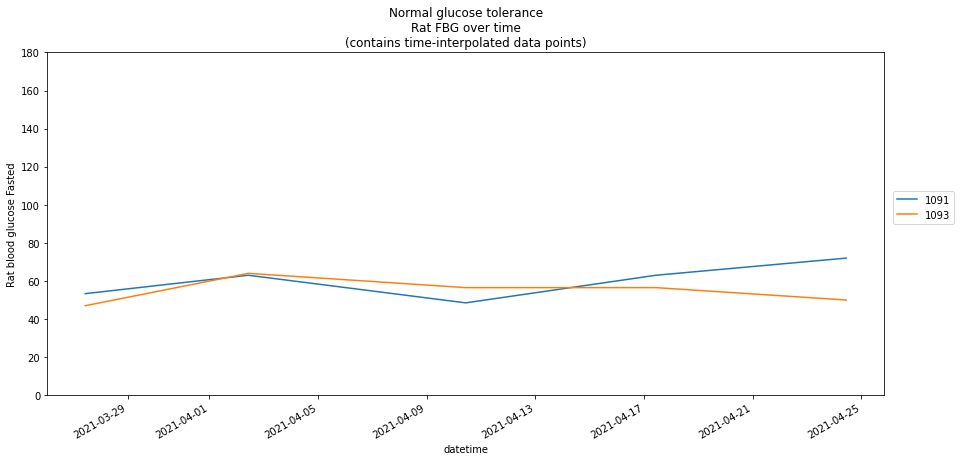

In [169]:
obs_used[(obs_used['BG type'] == 'FBG') & (obs_used['animal'].isin(normal)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 180)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Normal glucose tolerance\nRat FBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

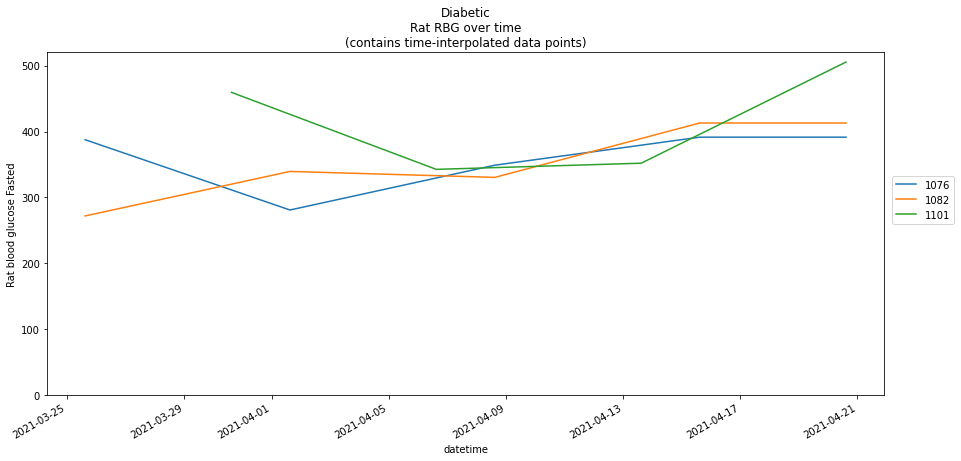

In [183]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['animal'].isin(diabetic)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 520)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Diabetic\nRat RBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

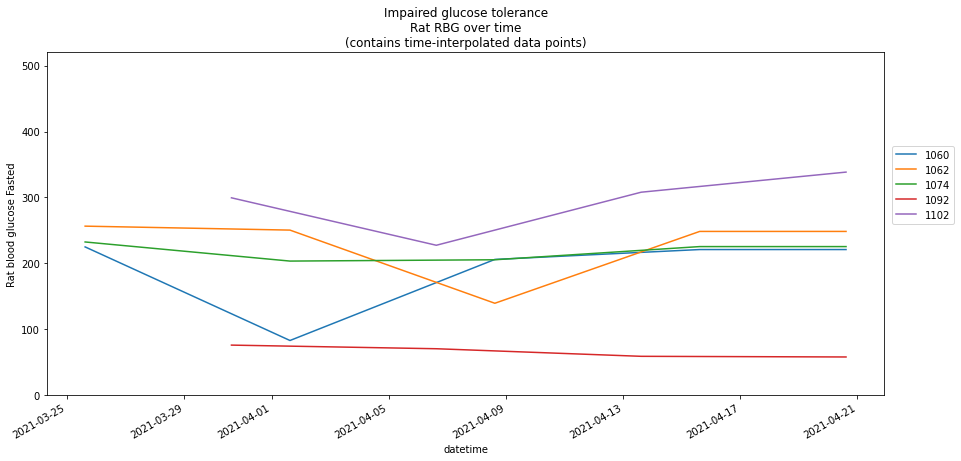

In [184]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['animal'].isin(impaired)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 520)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Impaired glucose tolerance\nRat RBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

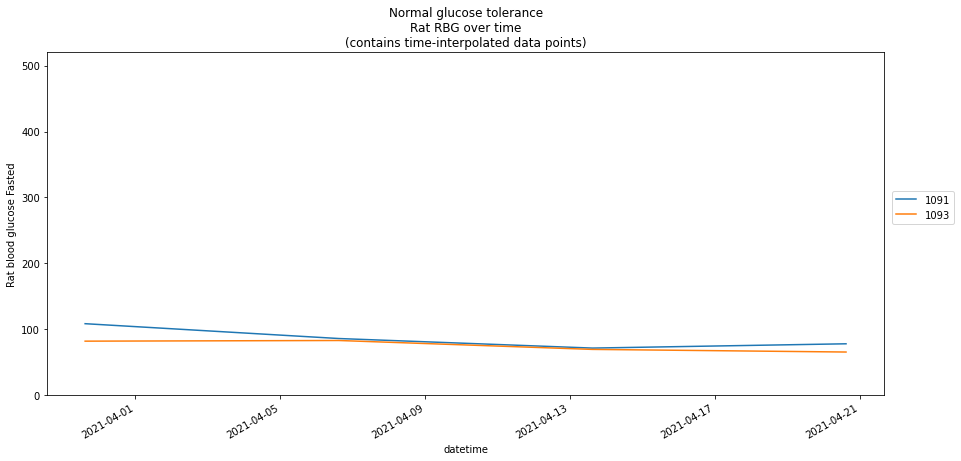

In [185]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['animal'].isin(normal)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 520)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Normal glucose tolerance\nRat RBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))